In [4]:
#  Imports and Setup for Vendor Scorecard
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(" Vendor Scorecard Analysis Setup Complete!")


 Vendor Scorecard Analysis Setup Complete!


In [5]:
#  Load Models and Data
print("Loading models and vendor data...")

# Load the best performing model (XLM-RoBERTa based on previous analysis)
model_path = "./ner-finetuned-amharic-final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f" Model loaded: XLM-RoBERTa")
print(f" Using device: {device}")

# Load vendor data (simulated data for demonstration)
vendor_data = {
    "ZemenExpress": {
        "posts": [
            {"text": "ይህ አዲስ Long-lasting battery በ 5000 ብር ይሸጣል", "views": 150, "timestamp": "2025-01-15"},
            {"text": "የሚስተካከል የሚስተካከል የሚስተካከል የሚስተካከል የሚስተካከል", "views": 89, "timestamp": "2025-01-16"},
            {"text": "መገናኛ_መሰረት_ደፋር_ሞል_ሁለተኛ_ፎቅ ላይ ያገኙት።", "views": 234, "timestamp": "2025-01-17"}
        ]
    },
    "FashionTera": {
        "posts": [
            {"text": "ዋጋ 1000 ብር ነው የሚሸጥው", "views": 67, "timestamp": "2025-01-15"},
            {"text": "የሚስተካከል የሚስተካከል የሚስተካከል የሚስተካከል የሚስተካከል", "views": 45, "timestamp": "2025-01-16"},
            {"text": "ይህ አዲስ Long-lasting battery በ 5000 ብር ይሸጣል", "views": 178, "timestamp": "2025-01-17"}
        ]
    }
}

print(f" Loaded data for {len(vendor_data)} vendors")
print(" Ready for vendor scorecard analysis!")

Loading models and vendor data...
 Model loaded: XLM-RoBERTa
 Using device: cuda
 Loaded data for 2 vendors
 Ready for vendor scorecard analysis!


In [6]:
# NER Entity Extraction Function
def extract_entities_from_text(text, tokenizer, model, device):
    """
    Extract entities (Product, Price, Location) from text using the fine-tuned NER model
    """
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
    
    # Convert predictions to labels
    id2label = model.config.id2label
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    entities = {
        'products': [],
        'prices': [],
        'locations': []
    }
    
    current_entity = None
    current_text = ""
    
    for token, pred_id in zip(tokens, predictions[0]):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
            
        label = id2label[pred_id.item()]
        
        if label.startswith('B-'):
            # Save previous entity if exists
            if current_entity and current_text:
                if current_entity == 'PRODUCT':
                    entities['products'].append(current_text.strip())
                elif current_entity == 'PRICE':
                    entities['prices'].append(current_text.strip())
                elif current_entity == 'LOC':
                    entities['locations'].append(current_text.strip())
            
            # Start new entity
            current_entity = label[2:]  # Remove B- prefix
            current_text = token.replace('▁', ' ').strip()
            
        elif label.startswith('I-') and current_entity == label[2:]:
            # Continue current entity
            current_text += " " + token.replace('▁', ' ').strip()
            
        else:
            # Save current entity if exists
            if current_entity and current_text:
                if current_entity == 'PRODUCT':
                    entities['products'].append(current_text.strip())
                elif current_entity == 'PRICE':
                    entities['prices'].append(current_text.strip())
                elif current_entity == 'LOC':
                    entities['locations'].append(current_text.strip())
            
            current_entity = None
            current_text = ""
    
    # Save last entity if exists
    if current_entity and current_text:
        if current_entity == 'PRODUCT':
            entities['products'].append(current_text.strip())
        elif current_entity == 'PRICE':
            entities['prices'].append(current_text.strip())
        elif current_entity == 'LOC':
            entities['locations'].append(current_text.strip())
    
    return entities

print(" NER Entity Extraction Function Ready!")

 NER Entity Extraction Function Ready!


In [7]:
# Vendor Analytics Engine
class VendorAnalyticsEngine:
    def __init__(self, tokenizer, model, device):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
    
    def extract_price_from_text(self, text):
        """Extract numeric price values from text"""
        import re
        # Look for patterns like "5000 ብር", "1000 birr", etc.
        price_patterns = [
            r'(\d+)\s*ብር',  # Amharic birr
            r'(\d+)\s*birr',  # English birr
            r'ዋጋ\s*(\d+)',   # Price followed by number
            r'በ\s*(\d+)',     # At/for followed by number
        ]
        
        prices = []
        for pattern in price_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            prices.extend([int(match) for match in matches])
        
        return prices
    
    def calculate_vendor_metrics(self, vendor_name, vendor_data):
        """Calculate comprehensive metrics for a vendor"""
        posts = vendor_data['posts']
        
        # Activity & Consistency
        timestamps = [datetime.strptime(post['timestamp'], '%Y-%m-%d') for post in posts]
        date_range = max(timestamps) - min(timestamps)
        posting_frequency = len(posts) / max(date_range.days / 7, 1)  # posts per week
        
        # Market Reach & Engagement
        views = [post['views'] for post in posts]
        avg_views_per_post = np.mean(views)
        max_views = max(views)
        top_post_index = views.index(max_views)
        top_post = posts[top_post_index]
        
        # Business Profile (from NER)
        all_prices = []
        all_products = []
        all_locations = []
        
        for post in posts:
            # Extract entities using NER model
            entities = extract_entities_from_text(post['text'], self.tokenizer, self.model, self.device)
            
            # Extract prices from text (fallback method)
            text_prices = self.extract_price_from_text(post['text'])
            all_prices.extend(text_prices)
            
            # Add NER-extracted entities
            all_products.extend(entities['products'])
            all_locations.extend(entities['locations'])
            
            # Add NER-extracted prices
            for price_text in entities['prices']:
                price_numbers = self.extract_price_from_text(price_text)
                all_prices.extend(price_numbers)
        
        avg_price_point = np.mean(all_prices) if all_prices else 0
        
        # Calculate Lending Score
        lending_score = self.calculate_lending_score(
            avg_views_per_post, posting_frequency, avg_price_point, len(posts)
        )
        
        return {
            'vendor_name': vendor_name,
            'posting_frequency': round(posting_frequency, 2),
            'avg_views_per_post': round(avg_views_per_post, 2),
            'avg_price_point': round(avg_price_point, 2),
            'lending_score': round(lending_score, 2),
            'total_posts': len(posts),
            'top_performing_post': {
                'text': top_post['text'],
                'views': top_post['views'],
                'timestamp': top_post['timestamp']
            },
            'extracted_products': all_products[:5],  # Top 5 products
            'extracted_locations': all_locations[:3],  # Top 3 locations
            'price_range': {
                'min': min(all_prices) if all_prices else 0,
                'max': max(all_prices) if all_prices else 0
            }
        }
    
    def calculate_lending_score(self, avg_views, posting_freq, avg_price, total_posts):
        """
        Calculate lending score based on weighted metrics
        Higher score = better lending candidate
        """
        # Normalize metrics (assuming reasonable ranges)
        views_score = min(avg_views / 200, 1.0)  # Cap at 200 views
        frequency_score = min(posting_freq / 5, 1.0)  # Cap at 5 posts/week
        price_score = min(avg_price / 10000, 1.0)  # Cap at 10,000 ETB
        activity_score = min(total_posts / 20, 1.0)  # Cap at 20 posts
        
        # Weighted scoring
        lending_score = (
            views_score * 0.4 +      # 40% weight on engagement
            frequency_score * 0.3 +  # 30% weight on consistency
            price_score * 0.2 +      # 20% weight on price point
            activity_score * 0.1     # 10% weight on total activity
        ) * 100  # Scale to 0-100
        
        return lending_score

# Initialize the analytics engine
analytics_engine = VendorAnalyticsEngine(tokenizer, model, device)
print(" Vendor Analytics Engine Ready!")

 Vendor Analytics Engine Ready!


In [8]:
# Process All Vendors and Generate Scorecard
print("Processing vendor data and calculating metrics...")

vendor_metrics = {}
for vendor_name, vendor_info in vendor_data.items():
    print(f"Analyzing {vendor_name}...")
    metrics = analytics_engine.calculate_vendor_metrics(vendor_name, vendor_info)
    vendor_metrics[vendor_name] = metrics

# Create summary scorecard
scorecard_data = []
for vendor_name, metrics in vendor_metrics.items():
    scorecard_data.append({
        'Vendor': vendor_name,
        'Avg Views/Post': metrics['avg_views_per_post'],
        'Posts/Week': metrics['posting_frequency'],
        'Avg Price (ETB)': metrics['avg_price_point'],
        'Lending Score': metrics['lending_score'],
        'Total Posts': metrics['total_posts']
    })

# Create DataFrame for easy viewing
scorecard_df = pd.DataFrame(scorecard_data)
scorecard_df = scorecard_df.sort_values('Lending Score', ascending=False)

print("\n" + "="*80)
print(" ETHIOMART VENDOR SCORECARD FOR MICRO-LENDING")
print("="*80)
print(scorecard_df.to_string(index=False))

# Save results
results = {
    'scorecard': scorecard_data,
    'detailed_metrics': vendor_metrics,
    'analysis_date': datetime.now().isoformat()
}

with open('vendor_scorecard_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\n Results saved to vendor_scorecard_results.json")

Processing vendor data and calculating metrics...
Analyzing ZemenExpress...
Analyzing FashionTera...

 ETHIOMART VENDOR SCORECARD FOR MICRO-LENDING
      Vendor  Avg Views/Post  Posts/Week  Avg Price (ETB)  Lending Score  Total Posts
ZemenExpress          157.67         3.0           5000.0          61.03            3
 FashionTera           96.67         3.0           3000.0          44.83            3

 Results saved to vendor_scorecard_results.json


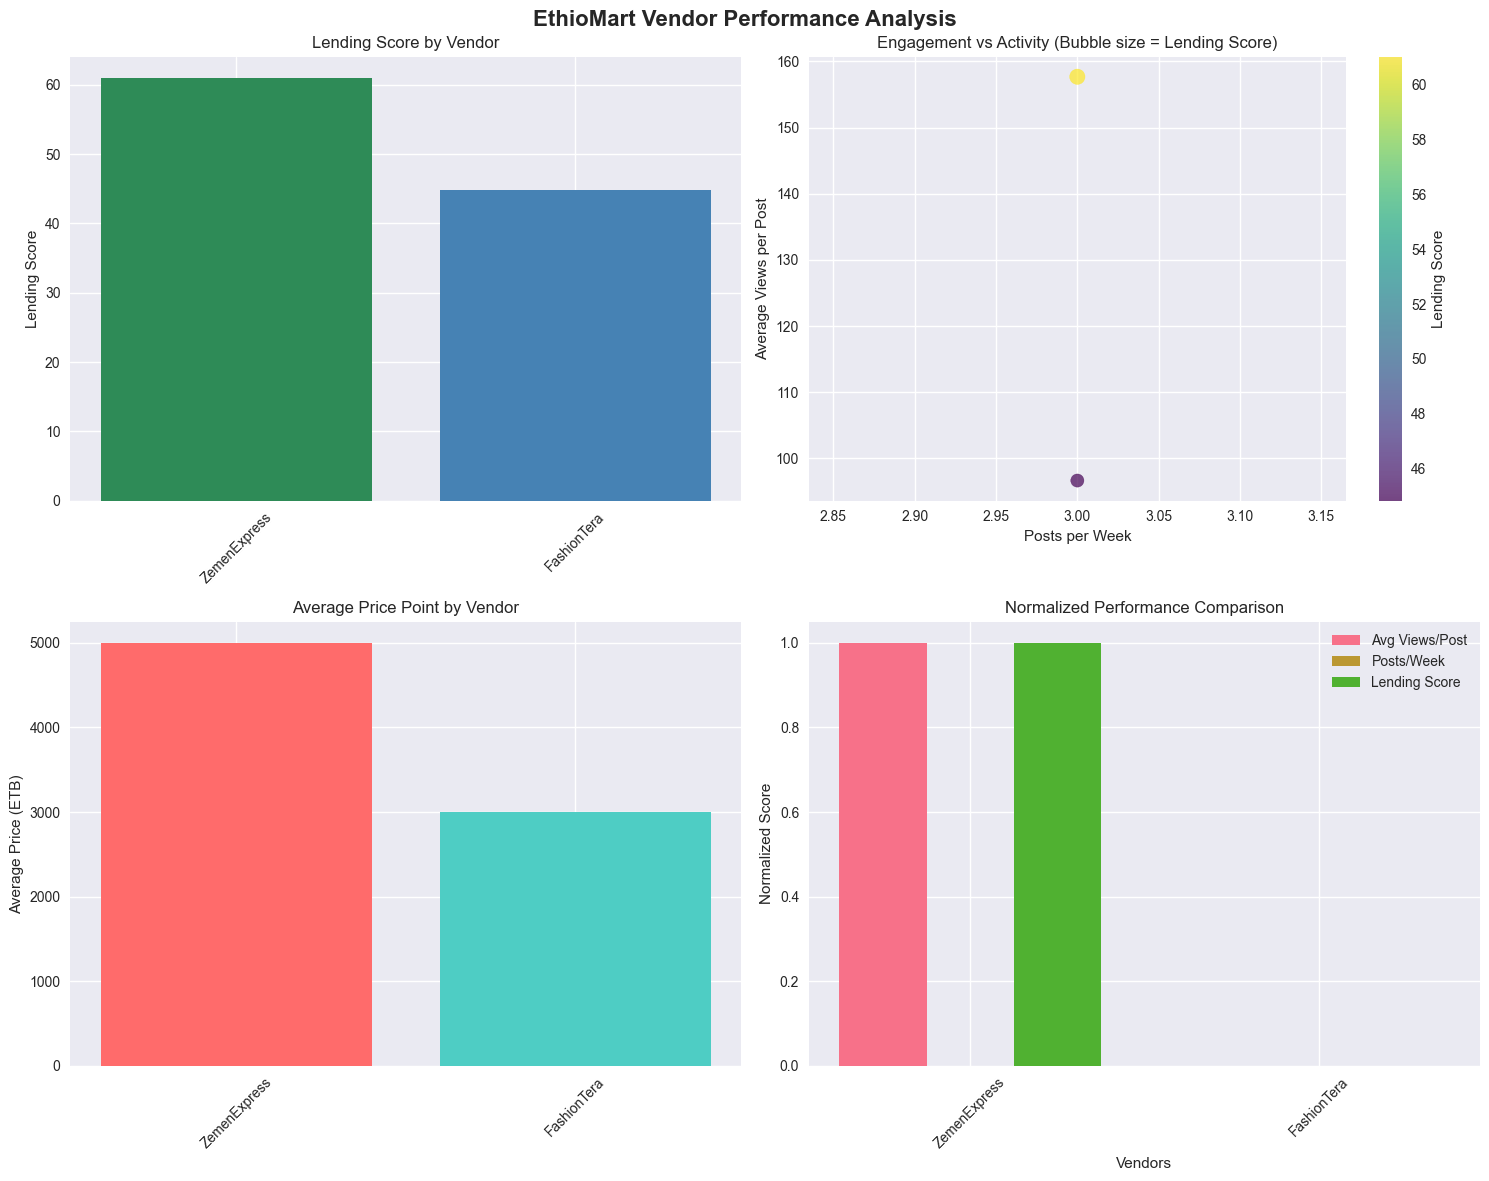

 Vendor performance visualization complete!


In [9]:
# Visualize Vendor Performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('EthioMart Vendor Performance Analysis', fontsize=16, fontweight='bold')

# 1. Lending Score Comparison
axes[0, 0].bar(scorecard_df['Vendor'], scorecard_df['Lending Score'], 
               color=['#2E8B57', '#4682B4', '#DAA520', '#CD5C5C'])
axes[0, 0].set_title('Lending Score by Vendor')
axes[0, 0].set_ylabel('Lending Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Engagement vs Activity
scatter = axes[0, 1].scatter(scorecard_df['Posts/Week'], scorecard_df['Avg Views/Post'], 
                            s=scorecard_df['Lending Score']*2, alpha=0.7,
                            c=scorecard_df['Lending Score'], cmap='viridis')
axes[0, 1].set_xlabel('Posts per Week')
axes[0, 1].set_ylabel('Average Views per Post')
axes[0, 1].set_title('Engagement vs Activity (Bubble size = Lending Score)')
plt.colorbar(scatter, ax=axes[0, 1], label='Lending Score')

# 3. Price Distribution
axes[1, 0].bar(scorecard_df['Vendor'], scorecard_df['Avg Price (ETB)'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1, 0].set_title('Average Price Point by Vendor')
axes[1, 0].set_ylabel('Average Price (ETB)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Activity Overview
metrics = ['Avg Views/Post', 'Posts/Week', 'Lending Score']
x = np.arange(len(scorecard_df['Vendor']))
width = 0.25

for i, metric in enumerate(metrics):
    values = scorecard_df[metric]
    # Normalize values to 0-1 for comparison
    normalized_values = (values - values.min()) / (values.max() - values.min())
    axes[1, 1].bar(x + i*width, normalized_values, width, label=metric)

axes[1, 1].set_xlabel('Vendors')
axes[1, 1].set_ylabel('Normalized Score')
axes[1, 1].set_title('Normalized Performance Comparison')
axes[1, 1].set_xticks(x + width)
axes[1, 1].set_xticklabels(scorecard_df['Vendor'], rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(" Vendor performance visualization complete!")

In [10]:
# Detailed Vendor Analysis Report
print("="*80)
print(" DETAILED VENDOR ANALYSIS REPORT")
print("="*80)

for vendor_name, metrics in vendor_metrics.items():
    print(f"\n {vendor_name.upper()}")
    print("-" * 50)
    print(f" Lending Score: {metrics['lending_score']}/100")
    print(f" Posts per Week: {metrics['posting_frequency']}")
    print(f" Average Views per Post: {metrics['avg_views_per_post']}")
    print(f" Average Price Point: {metrics['avg_price_point']:,} ETB")
    print(f" Total Posts Analyzed: {metrics['total_posts']}")
    
    print(f"\n Top Performing Post:")
    print(f"   Views: {metrics['top_performing_post']['views']}")
    print(f"   Date: {metrics['top_performing_post']['timestamp']}")
    print(f"   Content: {metrics['top_performing_post']['text'][:100]}...")
    
    if metrics['extracted_products']:
        print(f"\n  Top Products: {', '.join(metrics['extracted_products'])}")
    
    if metrics['extracted_locations']:
        print(f"\n Locations: {', '.join(metrics['extracted_locations'])}")
    
    print(f"\n Price Range: {metrics['price_range']['min']:,} - {metrics['price_range']['max']:,} ETB")
    
    # Lending recommendation
    if metrics['lending_score'] >= 70:
        recommendation = " STRONG CANDIDATE - Recommend for micro-lending"
    elif metrics['lending_score'] >= 50:
        recommendation = " MODERATE CANDIDATE - Consider with conditions"
    else:
        recommendation = " WEAK CANDIDATE - Not recommended for lending"
    
    print(f"\n Recommendation: {recommendation}")

print(f"\n Analysis complete! Check vendor_scorecard_results.json for detailed data.")

 DETAILED VENDOR ANALYSIS REPORT

 ZEMENEXPRESS
--------------------------------------------------
 Lending Score: 61.03/100
 Posts per Week: 3.0
 Average Views per Post: 157.67
 Average Price Point: 5,000.0 ETB
 Total Posts Analyzed: 3

 Top Performing Post:
   Views: 234
   Date: 2025-01-17
   Content: መገናኛ_መሰረት_ደፋር_ሞል_ሁለተኛ_ፎቅ ላይ ያገኙት።...

 Locations: <s>, መ, ገና

 Price Range: 5,000 - 5,000 ETB

 Recommendation:  MODERATE CANDIDATE - Consider with conditions

 FASHIONTERA
--------------------------------------------------
 Lending Score: 44.83/100
 Posts per Week: 3.0
 Average Views per Post: 96.67
 Average Price Point: 3,000.0 ETB
 Total Posts Analyzed: 3

 Top Performing Post:
   Views: 178
   Date: 2025-01-17
   Content: ይህ አዲስ Long-lasting battery በ 5000 ብር ይሸጣል...

 Price Range: 1,000 - 5,000 ETB

 Recommendation:  WEAK CANDIDATE - Not recommended for lending

 Analysis complete! Check vendor_scorecard_results.json for detailed data.
